In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
from lstm import lstm_model, prepare_and_split_data
from tensorflow.python.framework import dtypes
from tensorflow.contrib import learn

In [2]:
# MSE: 
LOG_DIR = './ops_logs/all_points_model'
TIMESTEPS = 5
RNN_LAYERS = [{'num_units': 40}, {'num_units': 20}]
DENSE_LAYERS = [10]
TRAINING_STEPS = 10000
PRINT_STEPS = TRAINING_STEPS / 10
BATCH_SIZE = 100

In [3]:
X, y = prepare_and_split_data(pd.read_csv('mydata.csv'), TIMESTEPS)

In [4]:
regressor = learn.Estimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS), model_dir=LOG_DIR)

In [5]:
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],every_n_steps=PRINT_STEPS,
                                                                                          early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'], monitors=[validation_monitor], batch_size=BATCH_SIZE, steps=TRAINING_STEPS)

Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.
Instructions for updating:
Please use tf.contrib.layers.stack instead.


Estimator(params=None)

In [24]:
predicted = regressor.predict(X['test'])
corrected_predictions = np.zeros(predicted.shape)

for i, time in enumerate(predicted):
    for j, point in enumerate(time):
        if point <=1.05:
            corrected_predictions[i,j] = 1.0
        else:
            corrected_predictions[i,j] = point

Instructions for updating:
Please use tf.contrib.layers.stack instead.


In [25]:
new_rmse = np.sqrt(((corrected_predictions - np.nan_to_num(y['test'])) ** 2).mean(axis=0))
new_score = mean_squared_error(corrected_predictions, np.nan_to_num(y['test']))
print ("NEW MSE: %f" % new_score)

NEW MSE: 0.029161


# plotting graphs below here

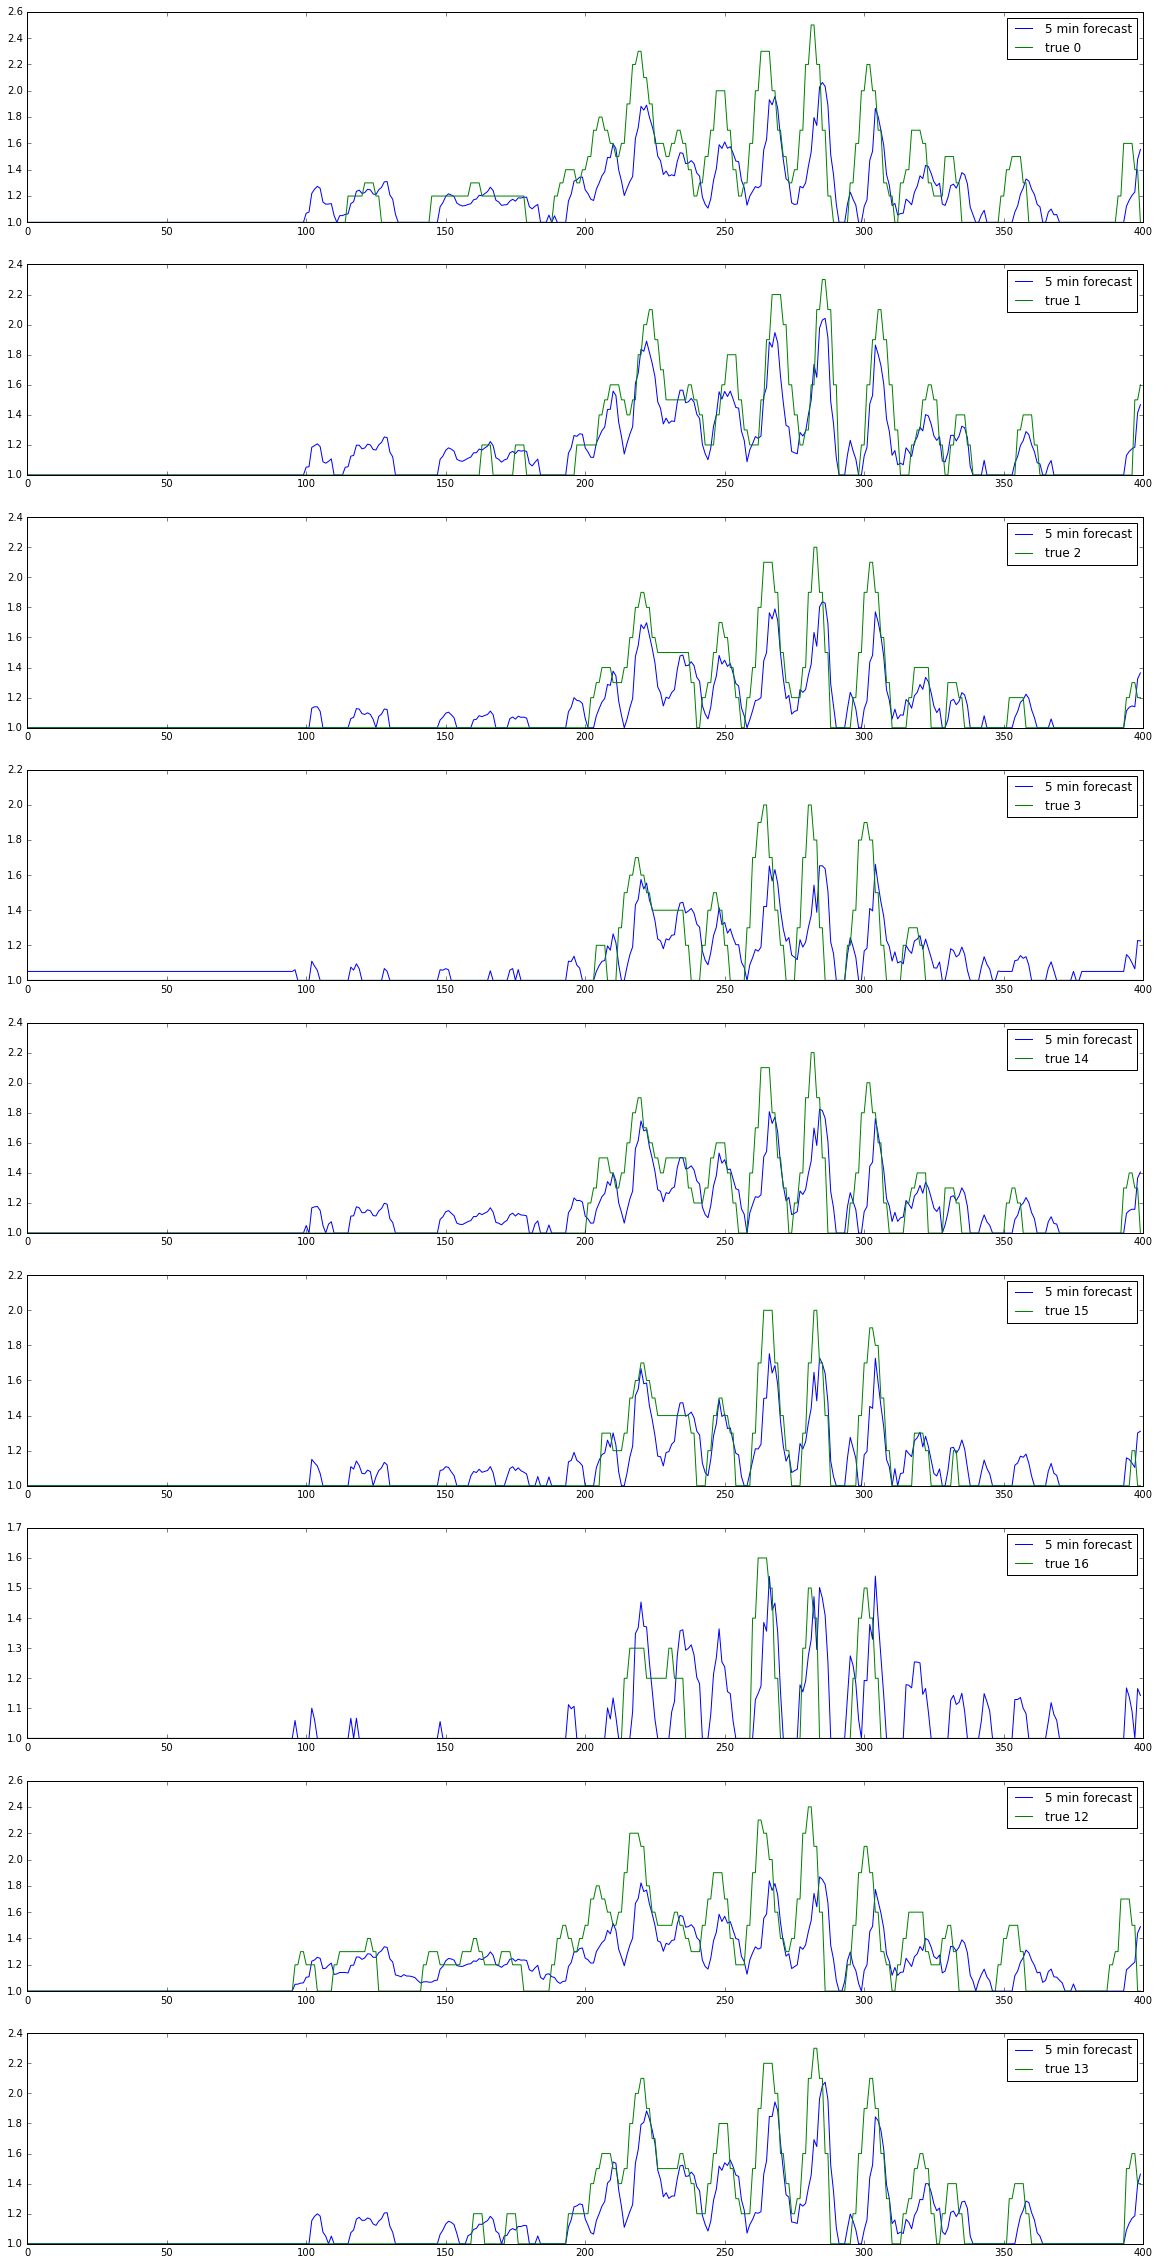

In [21]:
#[0, 1, 2, 3, 14, 15, 16, 12, 13
plt.figure(figsize=(20,40))

plt.subplot(911)
plt.plot(corrected_predictions[:,0][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,0][600:1000],label='true 0')
plt.legend()

plt.subplot(912)
plt.plot(corrected_predictions[:,1][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,1][600:1000],label='true 1')
plt.legend()

plt.subplot(913)
plt.plot(corrected_predictions[:,2][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,2][600:1000],label='true 2')
plt.legend()

plt.subplot(914)
plt.plot(corrected_predictions[:,3][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,3][600:1000],label='true 3')
plt.legend()

plt.subplot(915)
plt.plot(corrected_predictions[:,4][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,4][600:1000],label='true 14')
plt.legend()

plt.subplot(916)
plt.plot(corrected_predictions[:,5][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,5][600:1000],label='true 15')
plt.legend()

plt.subplot(917)
plt.plot(corrected_predictions[:,6][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,6][600:1000],label='true 16')
plt.legend()

plt.subplot(918)
plt.plot(corrected_predictions[:,7][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,7][600:1000],label='true 12')
plt.legend()

plt.subplot(919)
plt.plot(corrected_predictions[:,8][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,8][600:1000],label='true 13')
plt.legend()

plt.show()

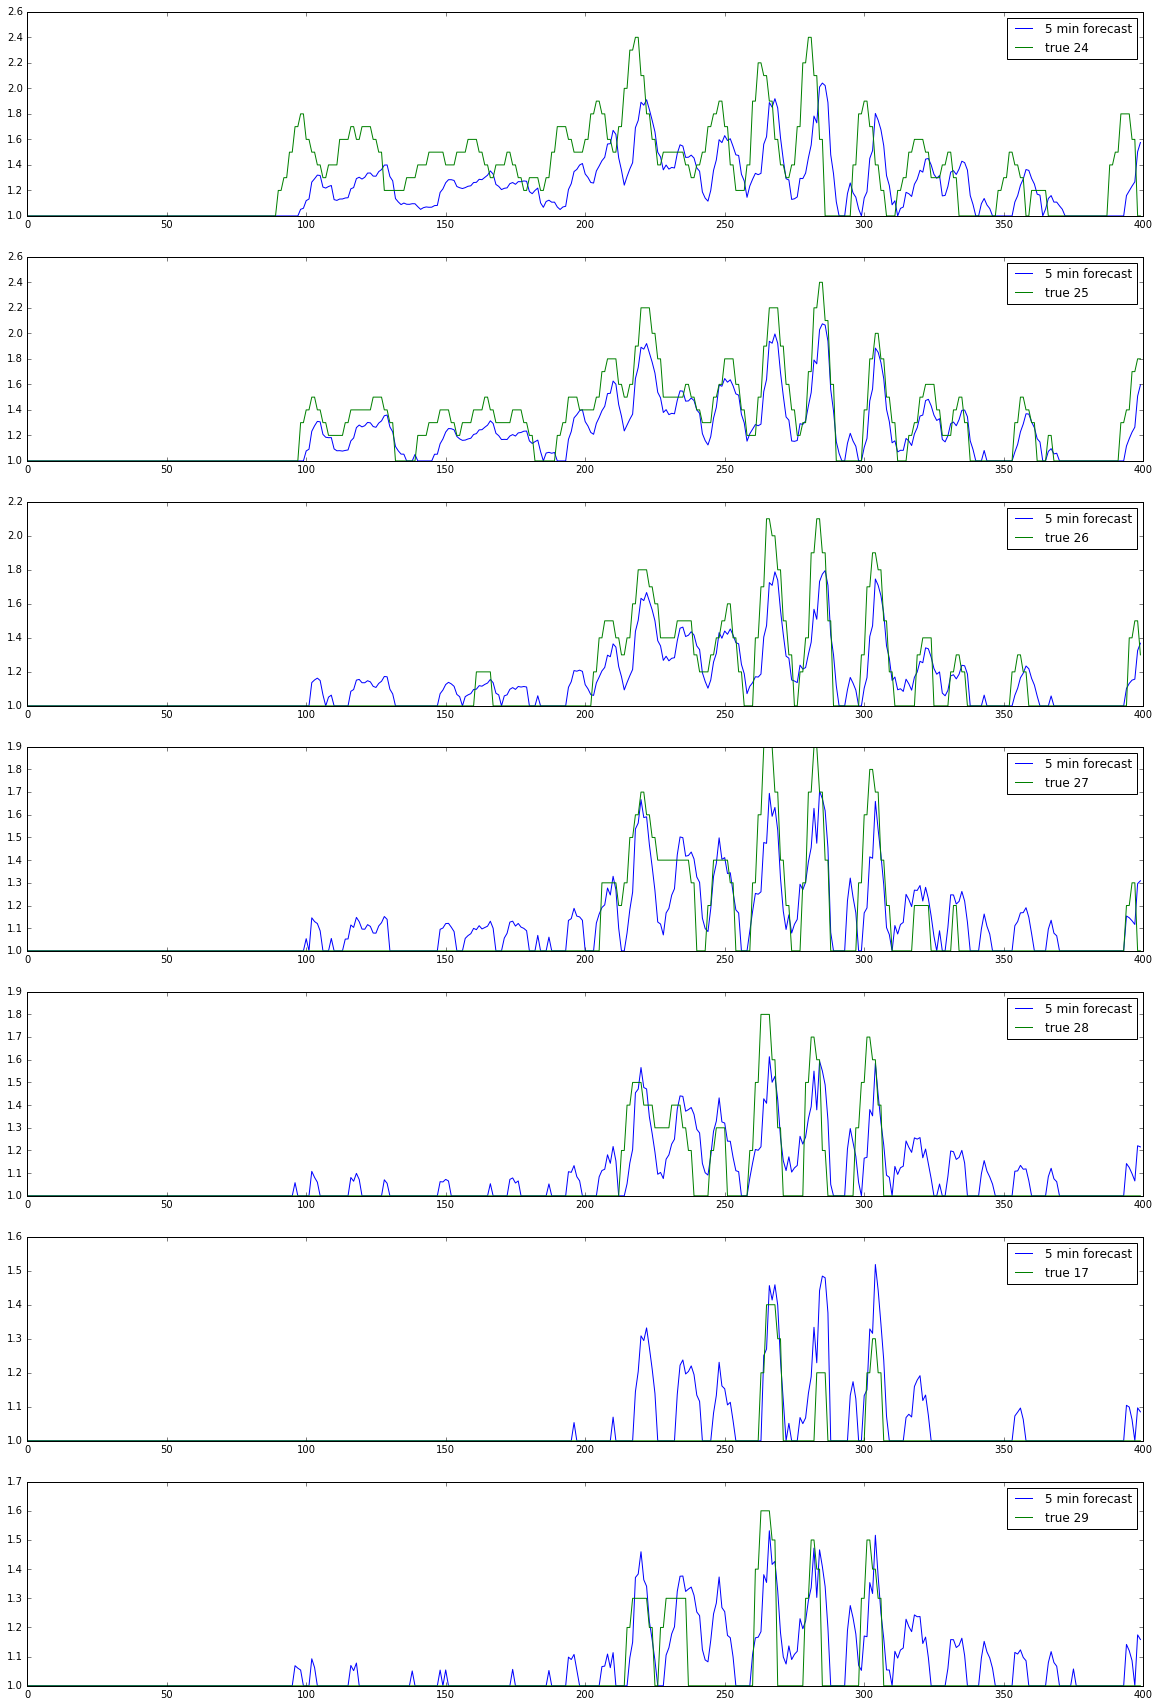

In [22]:
# , 24, 25, 26, 27, 28, 17, 29]
plt.figure(figsize=(20,30))

plt.subplot(711)
plt.plot(corrected_predictions[:,9][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,9][600:1000],label='true 24')
plt.legend()

plt.subplot(712)
plt.plot(corrected_predictions[:,10][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,10][600:1000],label='true 25')
plt.legend()

plt.subplot(713)
plt.plot(corrected_predictions[:,11][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,11][600:1000],label='true 26')
plt.legend()

plt.subplot(714)
plt.plot(corrected_predictions[:,12][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,12][600:1000],label='true 27')
plt.legend()

plt.subplot(715)
plt.plot(corrected_predictions[:,13][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,13][600:1000],label='true 28')
plt.legend()

plt.subplot(716)
plt.plot(corrected_predictions[:,14][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,14][600:1000],label='true 17')
plt.legend()

plt.subplot(717)
plt.plot(corrected_predictions[:,15][600:1000],label='5 min forecast')
plt.plot(np.nan_to_num(y['test'])[:,15][600:1000],label='true 29')
plt.legend()

plt.show()

# testing pickle stuff below here

In [ ]:
# Save Model Using Pickle
import pandas
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
import pickle

In [ ]:
def my_model():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
    names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
    dataframe = pandas.read_csv(url, names=names)
    array = dataframe.values
    X = array[:,0:8]
    Y = array[:,8]
    test_size = 0.33
    seed = 7
    X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=seed)
    model = LogisticRegression()
    model.fit(X_train, Y_train)

In [ ]:
model = my_model()

In [ ]:
f = 'test.sav'
pickle.dump(model, open(f,'wb'))

In [ ]:
loaded_model = pickle.load(open('test.sav', 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
# names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
# dataframe = pandas.read_csv(url, names=names)
# array = dataframe.values

In [ ]:
# X = array[:,0:8]
# Y = array[:,8]
# test_size = 0.33
# seed = 7
# X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [ ]:
# Fit the model on 33%
# model = LogisticRegression()
# model.fit(X_train, Y_train)

In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
import pickle

In [ ]:
class this_is_stupid():
    def so_dumb(self):
        print "I can't believe this shit."
        
    def still_crazy(self,x,y):
        x = x
        y = y
        print x + y

In [ ]:
model = this_is_stupid()

In [ ]:
model.still_crazy(4,5)

In [ ]:
filename = 'test.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('test.sav', 'rb'))

In [ ]:
data_string = pickle.dumps(model)

In [ ]:
print data_string